<a class="anchor" id="0"></a>
# [NLP : Reports & News Classification](https://www.kaggle.com/vbmokin/nlp-reports-news-classification)
## Automatic Environmental Reports & News Classification (Ukranian)

# Acknowledgements

This notebook uses such good notebooks: 
* BERT model from the paper with notebook [A Visual Guide to Using BERT for the First Time](http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/)
* EDA from the notebook [NLP - EDA, Bag of Words, TF IDF, GloVe, BERT](https://www.kaggle.com/vbmokin/nlp-eda-bag-of-words-tf-idf-glove-bert)
* Classification model from the notebook [Heart Disease - Automatic AdvEDA & FE & 20 models](https://www.kaggle.com/vbmokin/heart-disease-automatic-adveda-fe-20-models)
* similar my notebook [NLP for EN : BERT Classification for Water Report](https://www.kaggle.com/vbmokin/nlp-for-en-bert-classification-for-water-report)

My dataset [NLP : Reports & News Classification](https://www.kaggle.com/vbmokin/nlp-reports-news-classification)

Source of models:
https://huggingface.co/transformers/pretrained_models.html

<a class="anchor" id="0.1"></a>
## Table of Contents

1. [Import libraries](#1)
1. [Download data](#2)
1. [BERT: Data Prepairing and Modeling](#3)
1. [Text Classification and Prediction](#4)

## 1. Import libraries <a class="anchor" id="1"></a>

[Back to Table of Contents](#0.1)

In [3]:
!pip install --user transformers
!pip install --user torch

     ---------------------------------------- 4.0/4.0 MB 1.3 MB/s eta 0:00:00
     ---------------------------------------- 3.3/3.3 MB 784.4 kB/s eta 0:00:00
     ------------------------------------ 880.6/880.6 KB 994.7 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 77.9/77.9 KB 719.7 kB/s eta 0:00:00
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=963aaeb0451998302d378b1b378f55ebad3a36fc59a739d5d3bf50004d8f6f44
  Stored in directory: c:\users\dolla\appdata\local\pip\cache\wheels\12\1c\3d\46cf06718d63a32ff798a89594b61e7f345ab6b36d909ce033
Successfully built sacremoses



     -------------------------------------- 157.9/157.9 MB 1.2 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

import torch
import transformers as ppb

import warnings
warnings.filterwarnings('ignore')

## 2. Download data <a class="anchor" id="2"></a>

[Back to Table of Contents](#0.1)

In [8]:
df = pd.read_csv('water_problem_nlp_en_for_Kaggle_100.csv', delimiter=';', header=0, encoding='cp1251')
df = df.fillna(0)

convert_dict = {'text': str, 
                'env_problems': int,
                'pollution': int, 
                'treatment': int,
                'climate': int,
                'biomonitoring': int} 
  
df = df.astype(convert_dict)
df

,text,env_problems,pollution,treatment,climate,biomonitoring
0,In the Southern Bug basin wastewater is discha...,1,1,0,0,0
1,This amount is distributed as follows: urban a...,1,1,0,0,0
2,Despite the similar volumes of discharged wast...,1,1,0,0,0
3,They bring 84% of organic pollution 86% of pho...,1,1,0,0,0
4,The input of the industry is between 7вЂ“21% a...,1,1,0,0,0
...,...,...,...,...,...,...
95,Chemical composition of water bodies shall com...,0,0,0,0,0
96,According to the Directive provisions water bo...,0,0,0,0,0
97,Besides in the field of data processing during...,0,0,0,0,0
98,Use of these values was offered by the Monitor...,0,0,0,0,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           100 non-null    object
 1   env_problems   100 non-null    int32 
 2   pollution      100 non-null    int32 
 3   treatment      100 non-null    int32 
 4   climate        100 non-null    int32 
 5   biomonitoring  100 non-null    int32 
dtypes: int32(5), object(1)
memory usage: 2.9+ KB


## 3. BERT: Data Prepairing and Modeling <a class="anchor" id="3"></a>

[Back to Table of Contents](#0.1)

In [10]:
# For pre-trained DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-multilingual-cased')

# Other models: https://huggingface.co/transformers/pretrained_models.html

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Downloading: 100%|██████████| 972k/972k [00:02<00:00, 395kB/s]  
Downloading: 100%|██████████| 29.0/29.0 [00:00<00:00, 14.5kB/s]
Downloading: 100%|██████████| 466/466 [00:00<00:00, 158kB/s]
Downloading: 100%|██████████| 517M/517M [08:56<00:00, 1.01MB/s] 
Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
# Tokenization the sentences - break them up into word and subwords in the format BERT is comfortable with
tokenized = df['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
np.array(padded).shape

(100, 88)

In [12]:
# Creation variable to ignore (mask) the data padding
attention_mask = np.where(padded != 0, 1, 0)
print(attention_mask.shape)
attention_mask

(100, 88)


array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [13]:
# Modeling
input_ids = torch.tensor(padded).to(torch.int64)
attention_mask = torch.tensor(attention_mask).to(torch.int64)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [14]:
# Last hidden states
features = last_hidden_states[0][:,0,:].numpy()

## 4. Text Classification and Prediction <a class="anchor" id="4"></a>

[Back to Table of Contents](#0.1)

In [15]:
def target_prediction(df, features, target, test_size=0.2):
    # Text classification model and prediction for given feature "target" (with labels) in df
    
    # Target
    labels = df[target]
    
    # EDA
    print()
    # Extracting the number of examples of each class
    Relevant_len = df[df[target] == 1].shape[0]
    Not_len = df[df[target] == 0].shape[0]
    # Draw bar plot
    plt.rcParams['figure.figsize'] = (7, 5)
    plt.bar(10, Relevant_len, 3, label="Relevant", color='green')
    plt.bar(15, Not_len, 3, label="Not", color='red')
    plt.legend(loc='upper center')
    plt.ylabel('Number of examples')
    plt.title('Propertion of examples for ' + target)
    plt.show()
    
    # Train, test split 
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=test_size)
    
    # Train a simple model
    print(f'Classification for {col}:')
    parameters = {'C': np.linspace(0.0001, 100, 20)}
    model = GridSearchCV(LogisticRegression(), parameters)
    model.fit(train_features, train_labels)

    print('best parameters: ', model.best_params_)
    print('best scores: ', model.best_score_)
    
    # Test prediction
    test_pred = model.predict(test_features)
    print('Score of the test prediction -', accuracy_score(test_labels, test_pred),'\n\n')

In [16]:
# List of the target features in df
cols = df.columns.tolist()[1:]
print('Target columns:', cols)

Target columns: ['env_problems', 'pollution', 'treatment', 'climate', 'biomonitoring']


Solving NLP Classification tasks



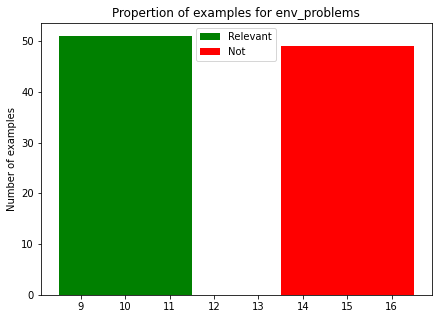

Classification for env_problems:
best parameters:  {'C': 36.842168421052634}
best scores:  0.9166666666666666
Score of the test prediction - 0.825 





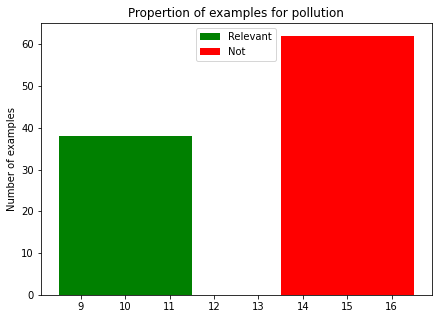

Classification for pollution:
best parameters:  {'C': 0.0001}
best scores:  0.6666666666666666
Score of the test prediction - 0.55 





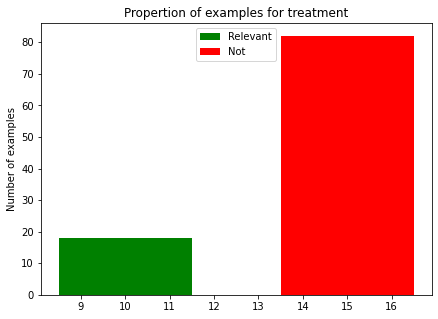

Classification for treatment:
best parameters:  {'C': 0.0001}
best scores:  0.85
Score of the test prediction - 0.775 





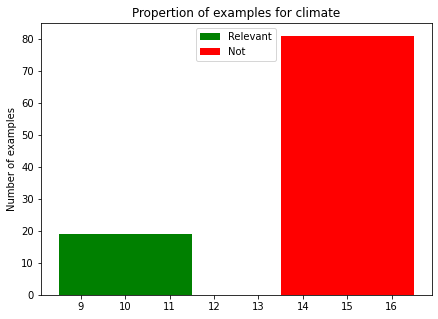

Classification for climate:
best parameters:  {'C': 5.263252631578947}
best scores:  0.9833333333333332
Score of the test prediction - 0.95 





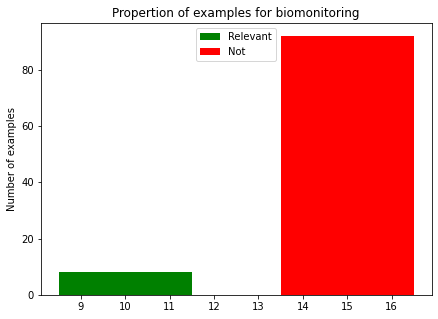

Classification for biomonitoring:
best parameters:  {'C': 0.0001}
best scores:  0.95
Score of the test prediction - 0.875 


Wall time: 26.5 s


In [17]:
%%time
# Solving NLP Classification tasks
print('Solving NLP Classification tasks')
for col in cols:
    target_prediction(df, features, col, test_size=0.4)

I hope you find this kernel useful and enjoyable.

Your comments and feedback are most welcome.

[Go to Top](#0)